# Evaluate the Effect of Temperature
See how the void growth rates and mobility terms change as a function of temperature

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load Results
Each of the result folders in [the void tracking directory](../1_void-tracking) are named after the temperature and contain a file which contains the void growth and mobility functions.

In [2]:
dynamics_terms = []
for path in Path('../1_void-tracking/output/').glob('8bitTIFF-*/model-parameters.json'):
    # Get the temperature
    temperature = float(path.parent.name.split("-")[-1][:-1])  # Directories are named [...]-[temp]C
    terms = {'temp': temperature}
    
    # Load the model parameters
    params = json.loads(path.read_text())
    for key, p in params.items():
        # The terms are always in the same order.
        
        for name, v in zip(['alpha.0', 'alpha.1', 'beta.0', 'beta.1'], p):
            terms[f'{key}.{name}'] = v
    
    dynamics_terms.append(terms)
dynamics_terms = pd.DataFrame(dynamics_terms).sort_values('temp')

In [3]:
dynamics_terms

,temp,growth.alpha.0,growth.alpha.1,growth.beta.0,growth.beta.1,movement.alpha.0,movement.alpha.1,movement.beta.0,movement.beta.1
0,525.0,-0.001213,-0.000247,-1.633784,-0.112717,-1.973680,-0.560920,0.026094,0.015193
4,550.0,-0.004154,0.000052,-1.323378,0.019620,-3.110522,-0.132544,0.204095,-0.001699
2,575.0,-0.001035,0.000251,-1.534878,-0.089190,-2.475411,-0.435299,0.101311,-0.011161
5,600.0,-0.000173,0.000525,-1.372825,0.025640,-2.366270,0.144712,0.103735,-0.006032
3,625.0,-0.001192,0.000904,-2.126776,0.003360,-2.424928,-0.234314,0.088119,0.004439
1,650.0,0.003771,0.000251,-1.675941,-0.008727,-0.630387,0.111333,0.172013,-0.006124


## Plot the Effect of Temperature on Growth
See if there is a consistent trend

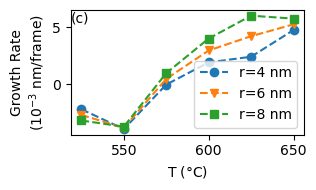

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for r, m in zip([4, 6, 8], 'ovs'):
    ax.errorbar(dynamics_terms['temp'],
                y=(dynamics_terms['growth.alpha.0'] + r * dynamics_terms['growth.alpha.1']) * 1e3,
                #yerr=np.power(10, dynamics_terms['growth.beta.0'] + r * dynamics_terms['growth.beta.1']), 
               fmt=f'--{m}', label=f'r={r} nm')

ax.text(0, 0.9, '(c)', transform=ax.transAxes, fontsize=10)
ax.set_xlabel('T ($\\degree$C)')
ax.set_ylabel('Growth Rate\n($10^{-3}$ nm/frame)')
ax.legend()
#ax.set_ylim(-0.02, 0.02)

fig.tight_layout()
fig.savefig('figures/growth-vs-temperature.png', dpi=320)